In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

#Loading Data

In [7]:
df = pd.read_csv('/content/weather_prediction_dataset.csv')
print(df.head())

       DATE  MONTH  BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
0  20000101      1                  8            0.89          1.0286   
1  20000102      1                  8            0.87          1.0318   
2  20000103      1                  5            0.81          1.0314   
3  20000104      1                  7            0.79          1.0262   
4  20000105      1                  5            0.90          1.0246   

   BASEL_global_radiation  BASEL_precipitation  BASEL_sunshine  \
0                    0.20                 0.03             0.0   
1                    0.25                 0.00             0.0   
2                    0.50                 0.00             3.7   
3                    0.63                 0.35             6.9   
4                    0.51                 0.07             3.7   

   BASEL_temp_mean  BASEL_temp_min  ...  STOCKHOLM_temp_min  \
0              2.9             1.6  ...                -9.3   
1              3.6             2.7  ..

#EDA: Exploratory Data Analysis

##Dataset Exploration

In [8]:
# Basic overview
print("Dataset Overview")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nSummary Statistics:")
print(df.describe())

# Convert DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')

# Extract additional temporal features
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month
df['Day'] = df['DATE'].dt.day
df['Weekday'] = df['DATE'].dt.weekday
df['Season'] = df['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2]
                                  else 'Spring' if x in [3, 4, 5]
                                  else 'Summer' if x in [6, 7, 8]
                                  else 'Autumn')


Dataset Overview
       DATE  MONTH  BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
0  20000101      1                  8            0.89          1.0286   
1  20000102      1                  8            0.87          1.0318   
2  20000103      1                  5            0.81          1.0314   
3  20000104      1                  7            0.79          1.0262   
4  20000105      1                  5            0.90          1.0246   

   BASEL_global_radiation  BASEL_precipitation  BASEL_sunshine  \
0                    0.20                 0.03             0.0   
1                    0.25                 0.00             0.0   
2                    0.50                 0.00             3.7   
3                    0.63                 0.35             6.9   
4                    0.51                 0.07             3.7   

   BASEL_temp_mean  BASEL_temp_min  ...  STOCKHOLM_temp_min  \
0              2.9             1.6  ...                -9.3   
1              3.6   

##Visualising Trends

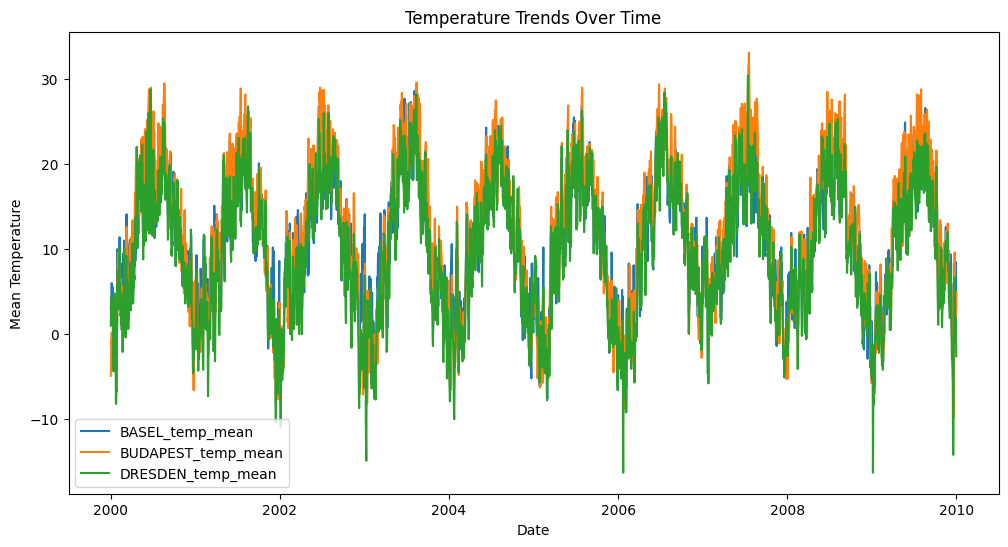

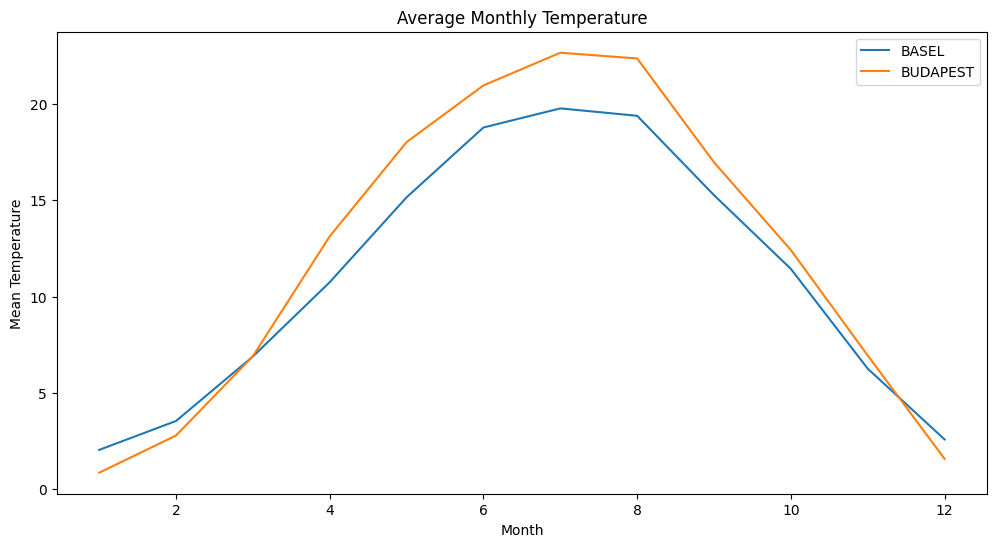

In [9]:
# Plot trends over time for temperature
plt.figure(figsize=(12, 6))
for city in ['BASEL_temp_mean', 'BUDAPEST_temp_mean', 'DRESDEN_temp_mean']:
    plt.plot(df['DATE'], df[city], label=city)
plt.title('Temperature Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

# Exclude non-numeric columns for aggregation
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Group by 'Month' and calculate mean for numeric columns only
monthly_data = df.groupby('Month')[numeric_columns].mean()

# Plot monthly aggregates for temperature
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['BASEL_temp_mean'], label='BASEL')
plt.plot(monthly_data.index, monthly_data['BUDAPEST_temp_mean'], label='BUDAPEST')
plt.title('Average Monthly Temperature')
plt.xlabel('Month')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

##Distribution Exploration

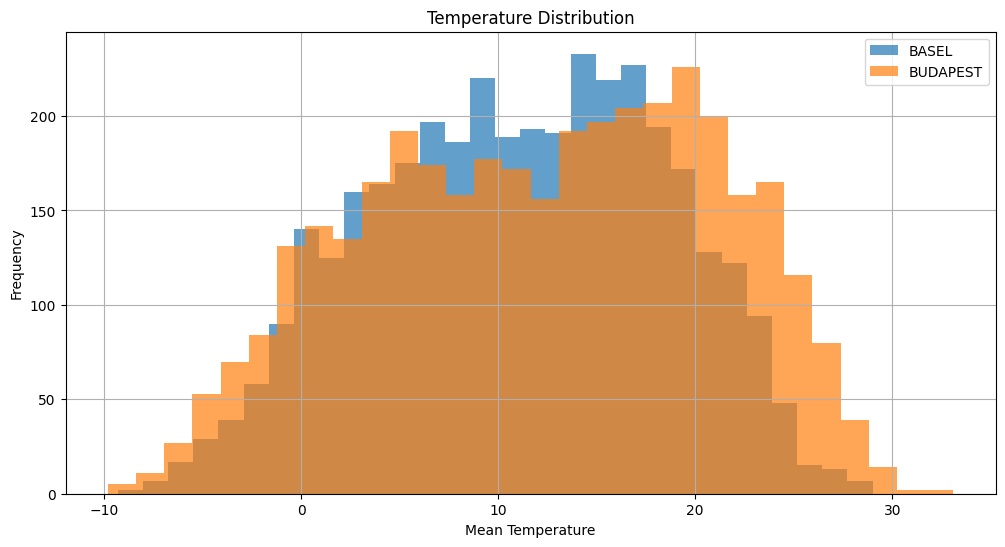

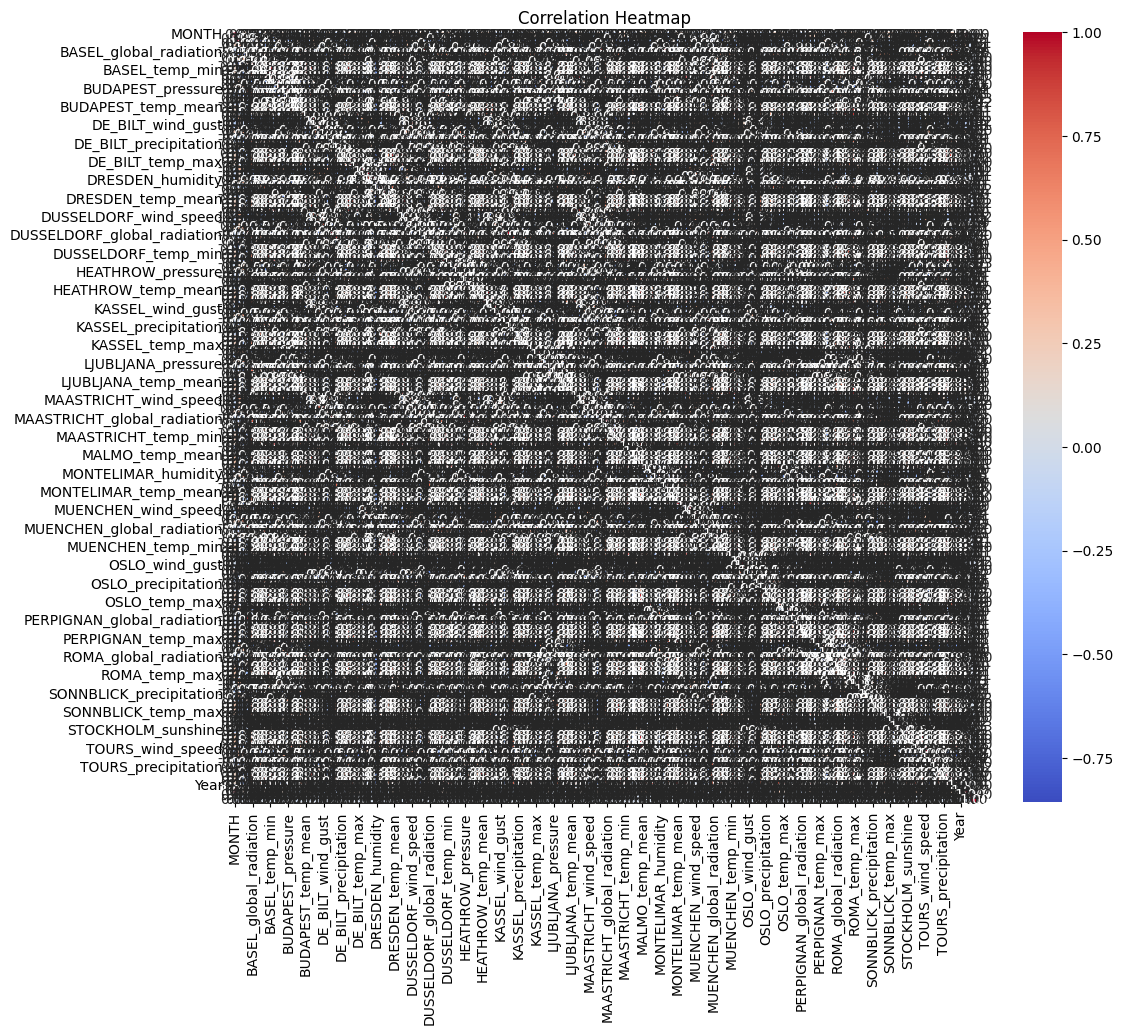

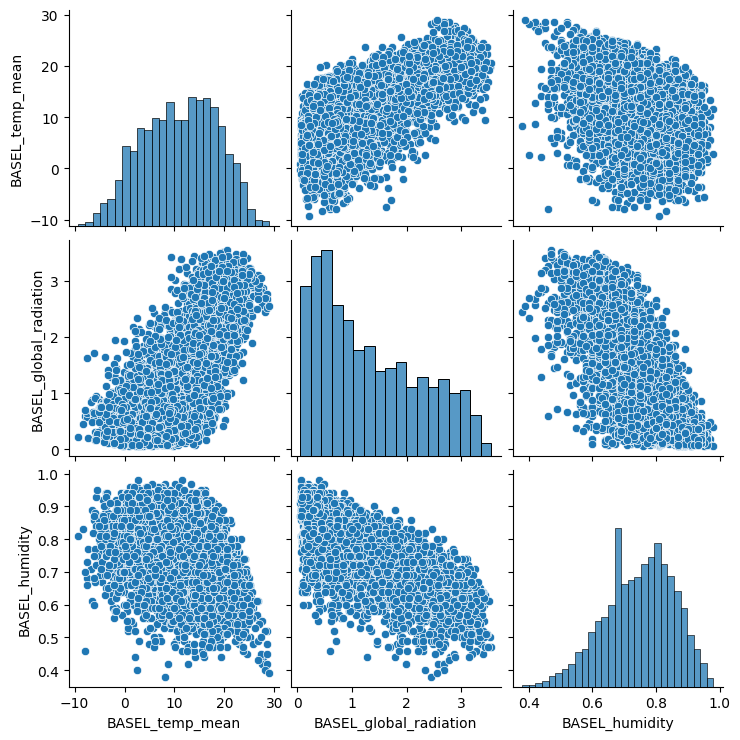

In [10]:
# Histograms
plt.figure(figsize=(12, 6))
df['BASEL_temp_mean'].hist(bins=30, alpha=0.7, label='BASEL')
df['BUDAPEST_temp_mean'].hist(bins=30, alpha=0.7, label='BUDAPEST')
plt.title('Temperature Distribution')
plt.xlabel('Mean Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=[np.number])

# Calculate correlation matrix
corr = numeric_columns.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Pairplot for select variables
sns.pairplot(df[['BASEL_temp_mean', 'BASEL_global_radiation', 'BASEL_humidity']])
plt.show()

##Handling missing values and outliers

In [11]:
# Handle numeric columns
numeric_columns = df.select_dtypes(include=[np.number])
df[numeric_columns.columns] = numeric_columns.fillna(numeric_columns.mean())

# Handle non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=[np.number])
df[non_numeric_columns.columns] = non_numeric_columns.fillna(non_numeric_columns.mode().iloc[0])

print("Missing values after imputation:")
print(df.isnull().sum())


# Detecting outliers with IQR method
def detect_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outliers = detect_outliers('BASEL_temp_mean')
print("\nOutliers in BASEL_temp_mean:")
print(outliers)


Missing values after imputation:
DATE                 0
MONTH                0
BASEL_cloud_cover    0
BASEL_humidity       0
BASEL_pressure       0
                    ..
Year                 0
Month                0
Day                  0
Weekday              0
Season               0
Length: 170, dtype: int64

Outliers in BASEL_temp_mean:
Empty DataFrame
Columns: [DATE, MONTH, BASEL_cloud_cover, BASEL_humidity, BASEL_pressure, BASEL_global_radiation, BASEL_precipitation, BASEL_sunshine, BASEL_temp_mean, BASEL_temp_min, BASEL_temp_max, BUDAPEST_cloud_cover, BUDAPEST_humidity, BUDAPEST_pressure, BUDAPEST_global_radiation, BUDAPEST_precipitation, BUDAPEST_sunshine, BUDAPEST_temp_mean, BUDAPEST_temp_max, DE_BILT_cloud_cover, DE_BILT_wind_speed, DE_BILT_wind_gust, DE_BILT_humidity, DE_BILT_pressure, DE_BILT_global_radiation, DE_BILT_precipitation, DE_BILT_sunshine, DE_BILT_temp_mean, DE_BILT_temp_min, DE_BILT_temp_max, DRESDEN_cloud_cover, DRESDEN_wind_speed, DRESDEN_wind_gust, DRESDEN_hum

##Advanced Visualisations

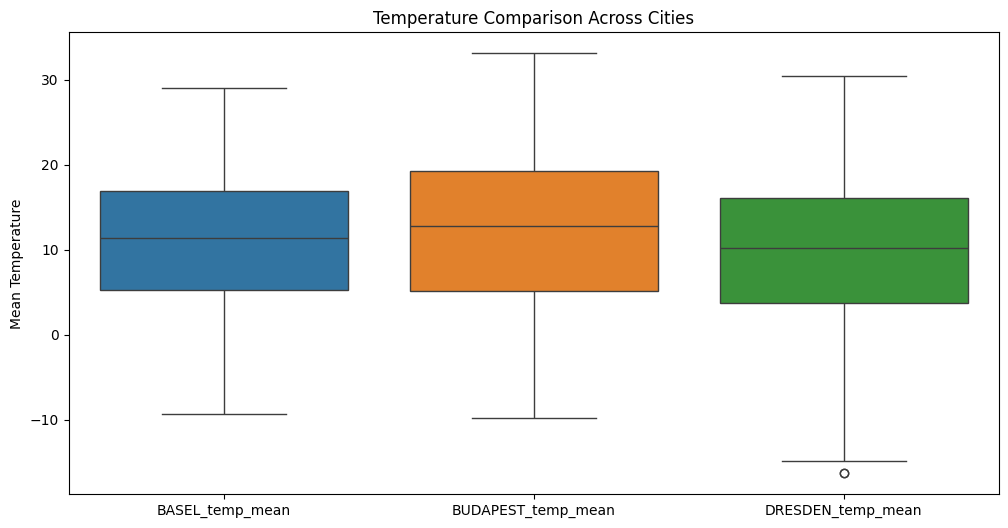

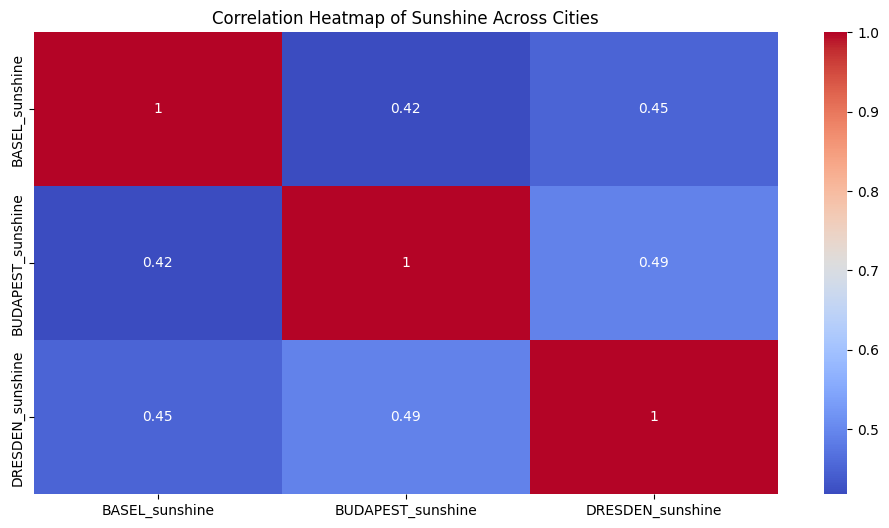

In [12]:
# Boxplot for temperature comparison across cities
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['BASEL_temp_mean', 'BUDAPEST_temp_mean', 'DRESDEN_temp_mean']])
plt.title('Temperature Comparison Across Cities')
plt.ylabel('Mean Temperature')
plt.show()

# City-wise Heatmap for Sunshine
plt.figure(figsize=(12, 6))
city_sunshine = df[['BASEL_sunshine', 'BUDAPEST_sunshine', 'DRESDEN_sunshine']]
sns.heatmap(city_sunshine.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Sunshine Across Cities')
plt.show()

##Feature Engineering

<ipython-input-13-4dbf9652ea74>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BASEL_temp_range'] = df['BASEL_temp_max'] - df['BASEL_temp_min']
<ipython-input-13-4dbf9652ea74>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BASEL_solar_efficiency'] = df['BASEL_global_radiation'] / (df['BASEL_sunshine'] + 1e-5)


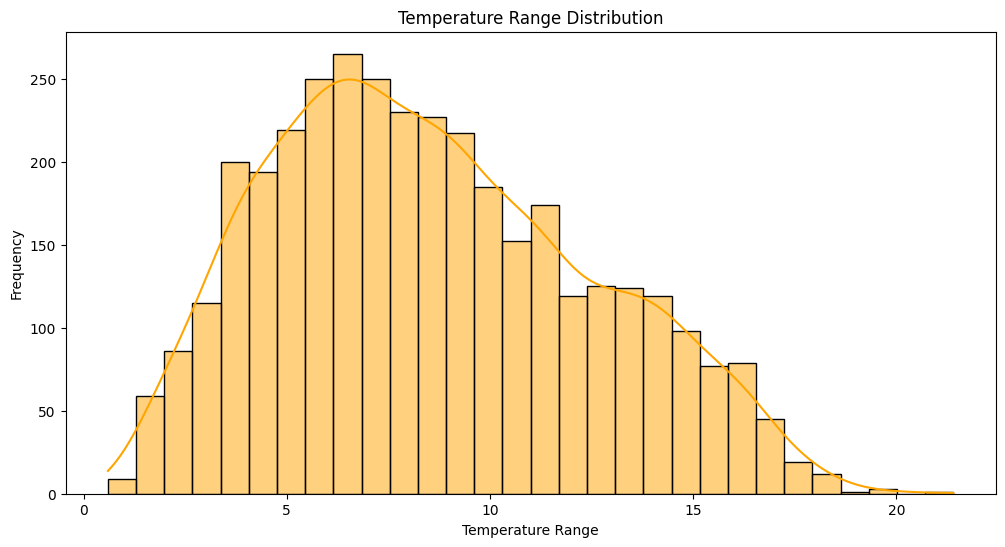

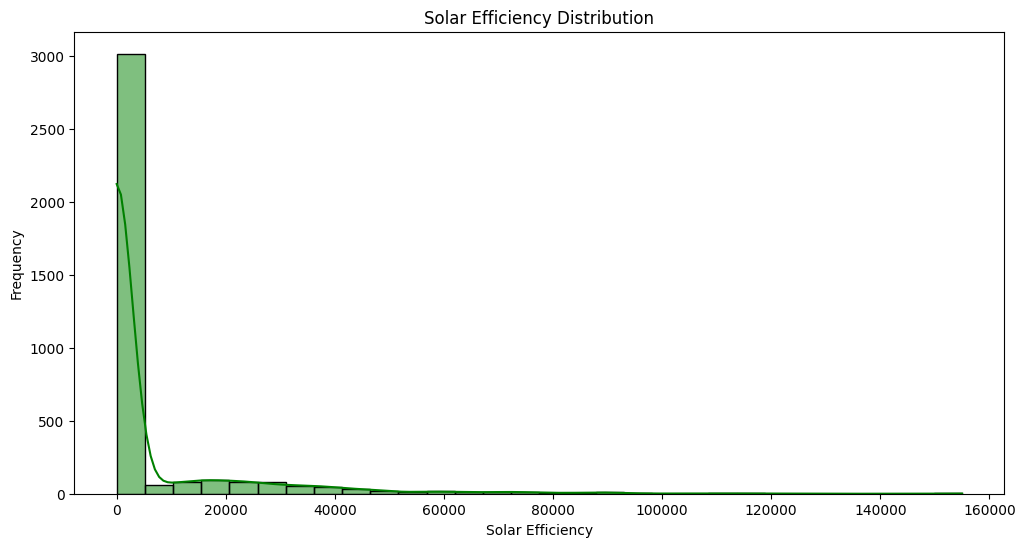

In [13]:
# Adding Temperature Range
df['BASEL_temp_range'] = df['BASEL_temp_max'] - df['BASEL_temp_min']

# Adding Solar Efficiency
df['BASEL_solar_efficiency'] = df['BASEL_global_radiation'] / (df['BASEL_sunshine'] + 1e-5)

# Visualize new features
plt.figure(figsize=(12, 6))
sns.histplot(df['BASEL_temp_range'], kde=True, bins=30, color='orange')
plt.title('Temperature Range Distribution')
plt.xlabel('Temperature Range')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df['BASEL_solar_efficiency'], kde=True, bins=30, color='green')
plt.title('Solar Efficiency Distribution')
plt.xlabel('Solar Efficiency')
plt.ylabel('Frequency')
plt.show()

#Model Prototyping

In [ ]:
# Feature selection
features = ['BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation']
target = 'BASEL_temp_mean'

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions and evaluation
y_pred = lr.predict(X_test)
print(f"Baseline RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")


Baseline RMSE: 4.19


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print(f"Random Forest RMSE: {mean_squared_error(y_test, y_pred_rf, squared=False):.2f}")


Random Forest RMSE: 4.28


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##Gradient Boosting

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
print(f"Gradient Boosting RMSE: {mean_squared_error(y_test, y_pred_gb, squared=False):.2f}")


Gradient Boosting RMSE: 4.42


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##Neural Networks

In [ ]:
# model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

# compile
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# train
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2)

# predictions and evaluation
y_pred_nn = model.predict(X_test)
print(f"Neural Network RMSE: {mean_squared_error(y_test, y_pred_nn, squared=False):.2f}")

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 184.3241 - mae: 11.5812 - val_loss: 163.4628 - val_mae: 10.5041
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 162.6299 - mae: 10.8422 - val_loss: 148.2644 - val_mae: 10.0129
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 150.2004 - mae: 10.3135 - val_loss: 130.4778 - val_mae: 9.4075
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 131.2901 - mae: 9.7335 - val_loss: 110.9455 - val_mae: 8.7071
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 107.5404 - mae: 8.7916 - val_loss: 89.0095 - val_mae: 7.8698
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 86.9631 - mae: 7.9935 - val_loss: 67.1924 - val_mae: 6.9026
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 58.5512 - mae: 6.5637 - val_loss: 49.4528 - val_mae: 5.9935
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 45.1915 - mae: 5.7914 - val_loss: 38.7043 - val_mae: 5.2723
Epoch 9/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#Metrics Table

In [ ]:
mae_lr = mean_absolute_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)


data = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Neural Network'],
    'RMSE': [mean_squared_error(y_test, y_pred, squared=False),
             mean_squared_error(y_test, y_pred_rf, squared=False),
             mean_squared_error(y_test, y_pred_gb, squared=False),
             mean_squared_error(y_test, y_pred_nn, squared=False)],
    'MAE': [mae_lr, mae_rf, mae_gb, mae_nn],
    'R^2': [r2_lr, r2_rf, r2_gb, r2_nn]
}
metrics_df = pd.DataFrame(data)
metrics_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

,Model,RMSE,MAE,R^2
0,Linear Regression,4.189593,3.338296,0.726336
1,Random Forest,4.275166,3.269934,0.715043
2,Gradient Boosting,4.420009,3.435740,0.695407
3,Neural Network,4.673043,3.849614,0.659535


#Feature importance of Models


Feature Importance of Linear Regression:
 BASEL_pressure            294.960009
BASEL_humidity             25.429114
BASEL_global_radiation      7.480325
dtype: float64

Feature Importance of Random Forest:
 BASEL_global_radiation    0.724249
BASEL_pressure            0.155650
BASEL_humidity            0.120101
dtype: float64

Feature Importance of Gradient Boosting:
 BASEL_global_radiation    0.773802
BASEL_pressure            0.133817
BASEL_humidity            0.092382
dtype: float64

Feature Importance of Neural Network:
 BASEL_global_radiation    0.204240
BASEL_pressure            0.163114
BASEL_humidity            0.136114
dtype: float32


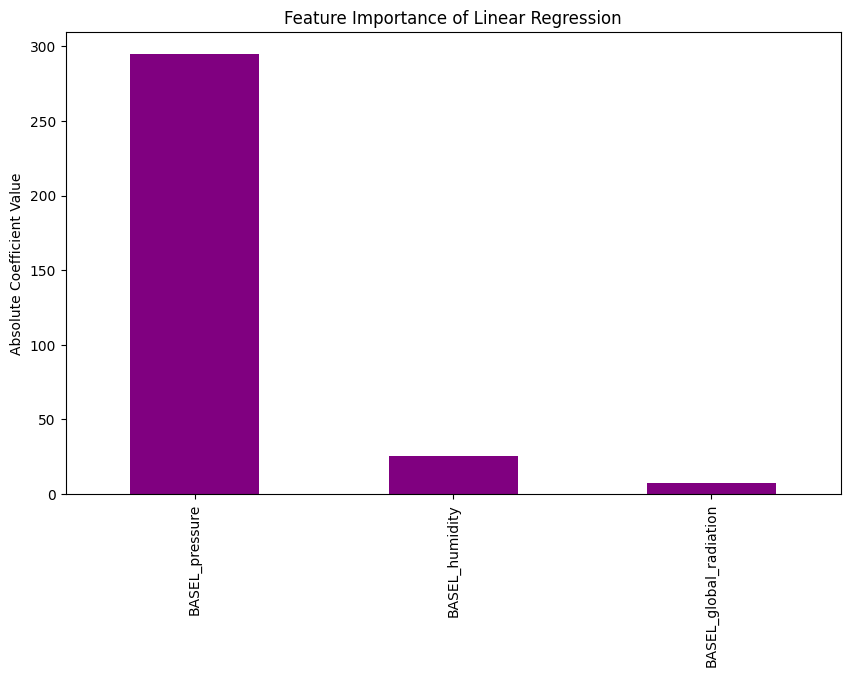

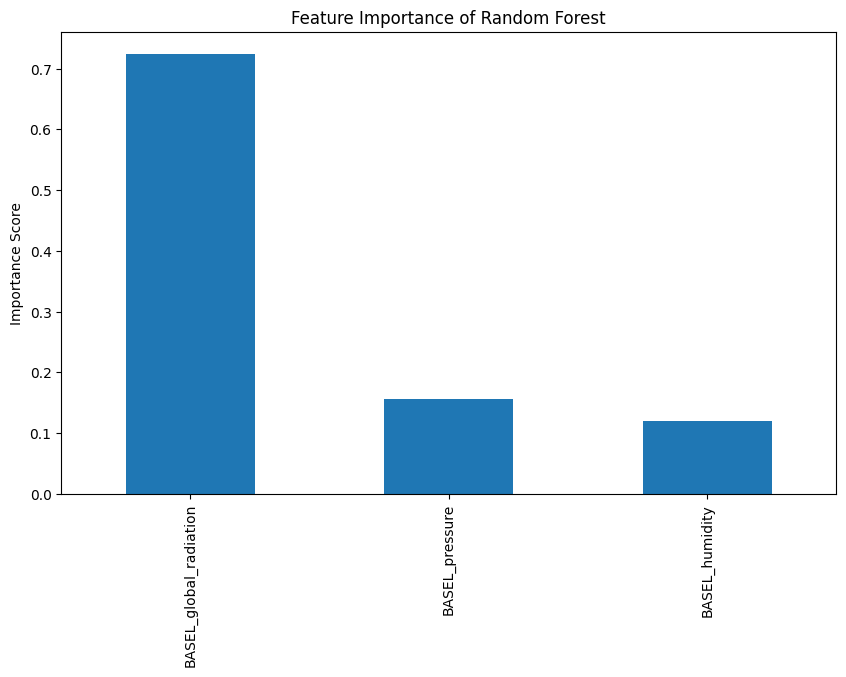

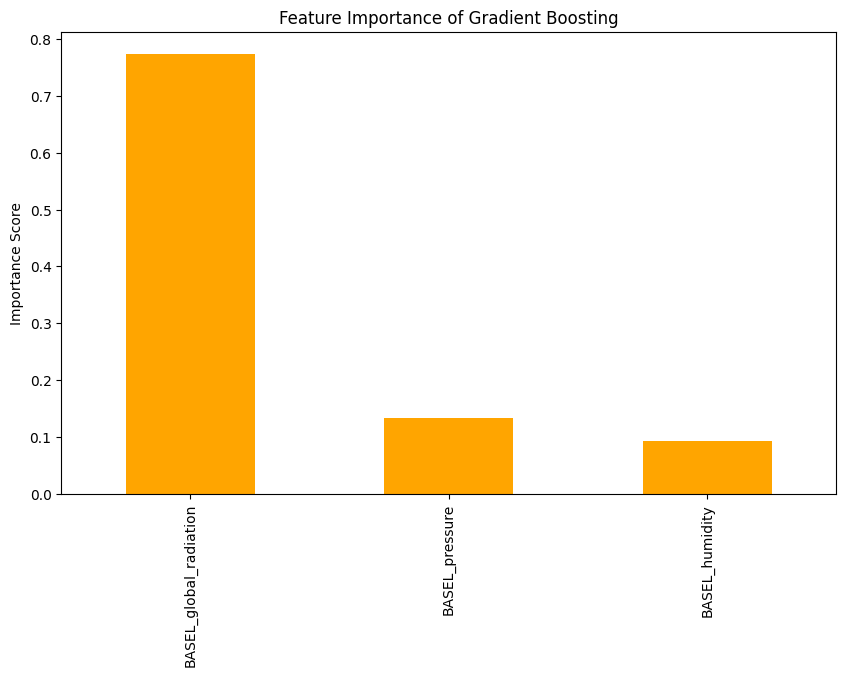

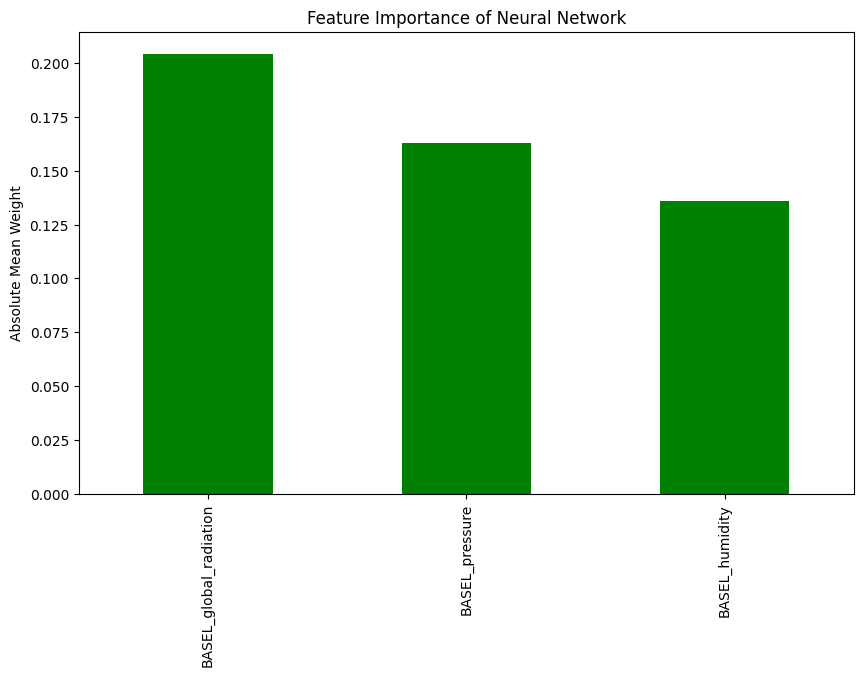

In [ ]:
feature_importance_lr = pd.Series(np.abs(lr.coef_), index=features).sort_values(ascending=False)
print("\nFeature Importance of Linear Regression:\n", feature_importance_lr)

feature_importance_rf = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importance of Random Forest:\n", feature_importance_rf)

feature_importance_gb = pd.Series(gb.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importance of Gradient Boosting:\n", feature_importance_gb)

weights = model.layers[0].get_weights()[0]
feature_importance_nn = pd.Series(np.abs(weights).mean(axis=1), index=features).sort_values(ascending=False)
print("\nFeature Importance of Neural Network:\n", feature_importance_nn)


plt.figure(figsize=(10, 6))
feature_importance_lr.plot(kind='bar', color='purple')
plt.title('Feature Importance of Linear Regression')
plt.ylabel('Absolute Coefficient Value')
plt.show()

plt.figure(figsize=(10, 6))
feature_importance_rf.plot(kind='bar')
plt.title('Feature Importance of Random Forest')
plt.ylabel('Importance Score')
plt.show()

plt.figure(figsize=(10, 6))
feature_importance_gb.plot(kind='bar', color='orange')
plt.title('Feature Importance of Gradient Boosting')
plt.ylabel('Importance Score')
plt.show()

plt.figure(figsize=(10, 6))
feature_importance_nn.plot(kind='bar', color='green')
plt.title('Feature Importance of Neural Network')
plt.ylabel('Absolute Mean Weight')
plt.show()


#Mathematical Analysis

In [ ]:
def analyze_model_complexity(model_name, model, X_train):

    complexity_metrics = {}
    complexity_metrics["Model Name"] = model_name
    if model_name == "Linear Regression":
        complexity_metrics["Number of Parameters"] = len(model.coef_) + 1
        complexity_metrics["Complexity"] = "Low"
    elif model_name == "Random Forest":
        complexity_metrics["Number of Trees"] = model.n_estimators
        complexity_metrics["Max Depth"] = model.max_depth
        complexity_metrics["Complexity"] = "Medium to High"
    elif model_name == "Gradient Boosting":
        complexity_metrics["Number of Trees"] = model.n_estimators
        complexity_metrics["Max Depth"] = model.max_depth
        complexity_metrics["Learning Rate"] = model.learning_rate
        complexity_metrics["Complexity"] = "Medium to High"
    elif model_name == "Neural Network":
        total_params = model.count_params()
        complexity_metrics["Number of Parameters"] = total_params
        complexity_metrics["Number of Layers"] = len(model.layers)
        complexity_metrics["Complexity"] = "High"
    else:
        complexity_metrics["Complexity"] = "Unknown"

    return complexity_metrics

complexity_analysis = []
complexity_analysis.append(analyze_model_complexity("Linear Regression", lr, X_train))
complexity_analysis.append(analyze_model_complexity("Random Forest", rf, X_train))
complexity_analysis.append(analyze_model_complexity("Gradient Boosting", gb, X_train))
complexity_analysis.append(analyze_model_complexity("Neural Network", model, X_train))

complexity_df = pd.DataFrame(complexity_analysis)
complexity_df

,Model Name,Number of Parameters,Complexity,Number of Trees,Max Depth,Learning Rate,Number of Layers
0,Linear Regression,4.0,Low,NaN,NaN,NaN,NaN
1,Random Forest,NaN,Medium to High,100.0,NaN,NaN,NaN
2,Gradient Boosting,NaN,Medium to High,100.0,3.0,0.1,NaN
3,Neural Network,2369.0,High,NaN,NaN,NaN,3.0


##Visualisation of complexities

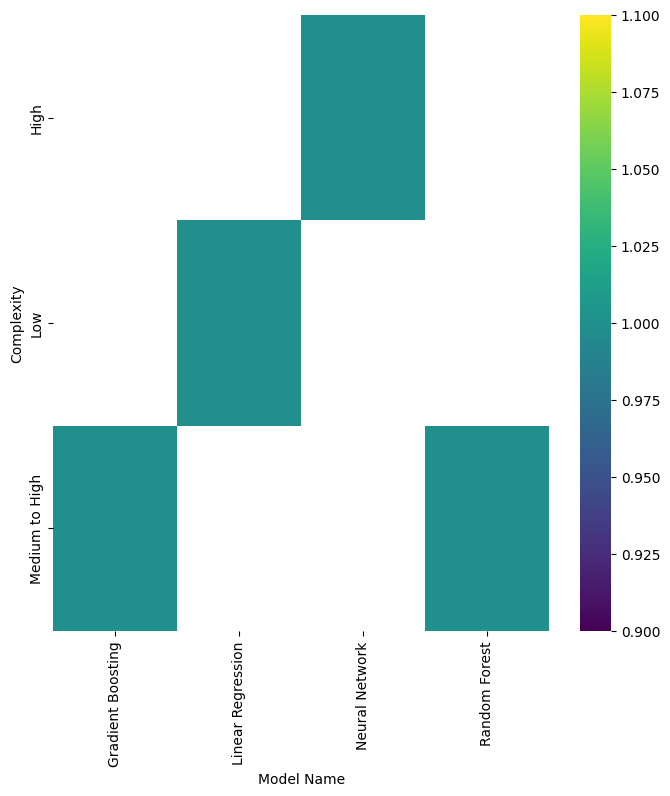

In [ ]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Complexity'].value_counts()
    for x_label, grp in complexity_df.groupby('Model Name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Model Name')
_ = plt.ylabel('Complexity')